In [1]:
import time
import calc
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib import cm
from matplotlib import rcParams as rcParams
rcParams['figure.dpi'] = 300
from scipy import interpolate
%matplotlib inline

# Basic investigation structure
nruns = 100
median_Hts = True          # If true, calculates mantle HPE budgets using median estimates in crust and BSE.
startpoint = 'latearc'   # starting time snapshot in model; present, phanero, latearc, midarc
endpoint = 'midarc'      # ending time snapshot in model; present, phanero, latearc, midarc
vary = 'Everything'      # Parameters to vary according to statistical distributions, or via gridding; see 'scenarios'
curves = [i for i in calc.curvenames] # Crustal growth curve to assume. Choose one or more from:
                         # ['HalfBy2.5', 'Linear', 'Sqrt', 'Fifth', 'HalfBy2.0', 'HalfBy2.5', 'HalfBy3.0', 'HalfBy3.5']
targetP = 1.5            # Reference pressure for thermochemical parameters
lowerrow = 0             # Where to find pressure in PerPlex file.

# Transition parameters from stagnant-lid to plate tectonic regime
duration=1.2
SL_at=4.0
SL_b=0.1
PT_at=2.5
PT_b=0.28

timestep=10.0 ** (-1 * calc.decimals)
tmin, tmax = calc.tmin, calc.tmax
assign_colors = cm.get_cmap('rainbow', len(calc.curvenames))
my_cm = dict(zip(calc.curvenames, np.linspace(0, 1, len(calc.curvenames))))
best_alpha = calc.cloud_alpha(nruns)
scenarios = {'Only_Start_End_Points': ['Ea_list', 'Qm_list', 'Tp_present'], 
    'Present_T_Flux' : ['Ea_list', 't_midarc', 'Tp_midarc', 't_latearc', 'Tp_latearc', 't_phanero', 'Tp_phanero'],
    'Rheology': ['t_midarc', 'Tp_midarc', 't_latearc', 'Tp_latearc', 't_phanero', 'Tp_phanero'],
    'TectonicTiming': ['Ea_list', 't_midarc', 'Tp_midarc', 't_latearc', 'Tp_latearc', 't_phanero', 'Tp_phanero'],
    'Everything': [],
       'HPEOnly': ['Ea_list', 'Qm_list', 'Tp_present', 't_midarc', 'Tp_midarc', 't_latearc', 'Tp_latearc', 't_phanero', 'Tp_phanero']
       }
constants = scenarios[vary]


In [2]:
Isos, bse_budgets, cr_budgets, bse_Ht_max, crust_Ht_max = calc.HPE_budgets(nruns=nruns, timestep=timestep, trange=[tmin, tmax])
if median_Hts==True:
    Isos, bse_budgets, cr_budgets, bse_Ht_max, crust_Ht_max = calc.HPE_budgets(nruns=nruns*10, timestep=timestep, trange=[tmin, tmax])
    bse_Ht_median = copy.deepcopy(calc.CI_rows(bse_Ht_max)['50%'])
    crust_Ht_median = copy.deepcopy(calc.CI_rows(crust_Ht_max)['50%'])
    bse_Ht_max, crust_Ht_max = pd.DataFrame(index=bse_Ht_max.index), pd.DataFrame(index=crust_Ht_max.index)
    for i in range(nruns):
        bse_Ht_max[i] = bse_Ht_median
        crust_Ht_max[i] = crust_Ht_median
cases = calc.case_defs(nruns=nruns, constants=constants)
beta_budgets = calc.beta_budgets(nruns=nruns, timestep=timestep, SL_at=SL_at, SL_b=SL_b, PT_at=PT_at, PT_b=PT_b, duration=duration)
GrowthCurves = calc.growth_models(timestep=timestep).loc[list(crust_Ht_max.index), :]
UM, LM, WM = calc.PTXgrids()
Pslice = calc.slice_PTXgrid(grid=UM, targetP=targetP, lowerrow=lowerrow)
pz = pd.read_csv('PREM.csv', header=0, usecols=[8,9])
z_fP = interpolate.interp1d(pz['Pressure(GPa)'], pz['Depth(km)'])
dT_fTp = 0.0 #0.35 * z_fP(targetP)
rho_fT = interpolate.interp1d(Pslice['Tp'], Pslice['rho'])
alpha_fT = interpolate.interp1d(Pslice['Tp'], Pslice['alpha'])
Cp_fT = interpolate.interp1d(Pslice['Tp'], Pslice['Cp'])
cases['rho_ref'] = rho_fT(cases['Tp_present']+dT_fTp)
cases['Cp_ref'] = Cp_fT(cases['Tp_present']+dT_fTp)
cases['alpha_ref'] = alpha_fT(cases['Tp_present']+dT_fTp)
cases['deltaT_ref'] = cases['Tp_present']-dT_fTp-300.0

if cases['t_'+startpoint].mean()>cases['t_'+endpoint].mean():
    direction = -1  # running model FORWARD in time
    starttdiff = []
    endtdiff = []
    for i in range(len(cases.index)):
        starttdiff.append(cases['t_'+startpoint].iloc[i] - calc.round_down(cases['t_'+startpoint].iloc[i]))
        endtdiff.append(calc.round_up(cases['t_'+endpoint].iloc[i]) - cases['t_'+endpoint].iloc[i])
else:
    direction = 1  # running model BACKWARD in time
    starttdiff = []
    endtdiff = []
    for i in range(len(cases.index)):
        starttdiff.append(calc.round_up(cases['t_'+startpoint].iloc[i]) - cases['t_'+startpoint].iloc[i])
        endtdiff.append(cases['t_'+endpoint].iloc[i] - calc.round_down(cases['t_'+endpoint].iloc[i]))

cases['endtdiff'] = endtdiff
cases['starttdiff'] = starttdiff
runs = cases.transpose()

calc.CI_cols(cases[list(i for i in cases if i!='Ea_list')])

,Qm_list,Tp_latearc,Tp_midarc,Tp_phanero,Tp_present,t_latearc,t_midarc,t_phanero,t_present,rho_ref,Cp_ref,alpha_ref,deltaT_ref,endtdiff,starttdiff
2.3%,29.706924,1806.447738,1766.771714,1635.777957,1538.461439,2.688189,3.136110,0.245010,0.0,3165.832088,1259.657775,0.000037,1238.461439,0.000171,0.000195
15.9%,33.053637,1824.122929,1830.723505,1641.100972,1574.702574,2.720507,3.234955,0.266156,0.0,3167.433201,1263.311726,0.000037,1274.702574,0.001223,0.001352
50%,36.937752,1840.656576,1895.172068,1652.176575,1607.550910,2.758263,3.361913,0.303232,0.0,3172.515132,1266.737087,0.000038,1307.550910,0.004582,0.004579
84.1%,41.169488,1858.830221,1940.226287,1662.395830,1643.459179,2.779420,3.475320,0.330584,0.0,3176.452386,1270.697635,0.000039,1343.459179,0.007752,0.008335
97.7%,45.990478,1873.669774,1996.138050,1670.185117,1672.711761,2.800537,3.611498,0.357407,0.0,3178.707620,1274.069977,0.000039,1372.711761,0.009588,0.009682


for curve in GrowthCurves:
    # Apply crustal growth model to bulk silicate earth radionuclide budget.
    mantle_Ht_max = calc.impose_growth_models_on_mantle(models=[curve],
        GrowthCurves=GrowthCurves, bse_df=bse_Ht_max, crust_df=crust_Ht_max)
    summary = calc.CI_rows(mantle_Ht_max)
    plt.plot(summary, c=assign_colors(my_cm[curve])) #, alpha=0.2)
plt.title('Uncertainty in Heat Production')
plt.show()

In [3]:
outputs = pd.DataFrame(index=GrowthCurves.index)

plt.figure(figsize=(9,6))
curves = [i for i in GrowthCurves] #'HalfBy3.5']          # ['HalfBy2.5', 'Linear', 'Sqrt', 'Fifth', 'HalfBy2.0', 'HalfBy2.5', 'HalfBy3.0', 'HalfBy3.5']

for curve in curves:
    # Apply crustal growth model to bulk silicate earth radionuclide budget.
    mantle_Ht_max = calc.impose_growth_models_on_mantle(models=[curve], GrowthCurves=GrowthCurves, bse_df=bse_Ht_max, crust_df=crust_Ht_max)
    Tlist = len(runs.columns)*['NaN']  # Get ready to receive final mantle temperatures.
    
    for r in runs:  # For each case to be explored...
        Tp = runs[r]['Tp_'+startpoint]  # Pick an empirically-derived starting temperature...
        t_start = runs[r]['t_'+startpoint]  # ...at an empirically-derived starting time.
        Tps = [Tp]   # Get ready to receive a temperature history over time...
        ts = [t_start]  # ...and the times associated with each temperature snapshot.
        b = beta_budgets[r].loc[calc.round_up(t_start)]  # Find scaling exponent for heat loss at that starting time.
        H_start = mantle_Ht_max[r].loc[calc.round_up(t_start)]  # Find amount of heat production at starting time, in TW.
        Hts = mantle_Ht_max[r].loc[calc.round_down(t_start):calc.round_up(runs[r]['t_'+endpoint]):direction] # Get span within which to run model.

        now = [9.81**b, 2900.0**(3*b), 5.0**(-b), rho_fT(Tp)**(2*b), (alpha_fT(Tp)*Cp_fT(Tp))**b,
               (Tp-dT_fTp-300.0)**(b+1), np.exp(runs[r]['Ea_list']/(calc.R_idealgas*(Tp+dT_fTp)))**(-1*b)]
        ref = [9.81**PT_b, 2900.0**(3*PT_b), 5.0**(-1*PT_b), runs[r]['rho_ref']**(2*PT_b), (runs[r]['alpha_ref']*runs[r]['Cp_ref'])**PT_b,
               runs[r]['deltaT_ref']**(PT_b+1), np.exp(runs[r]['Ea_list']/(calc.R_idealgas*(runs[r]['Tp_present']+dT_fTp)))**(-1*PT_b)]
        refstate = np.prod(ref)
        Q_start = runs[r]['Qm_list'] * (np.prod(now)/refstate)  # Estimate present heat loss as multiple of reference state.
        dT = (direction * runs[r]['starttdiff'] *  # Get temp diff between reference time and pre-calculated grid of times.
                   calc.seconds*1.0e12*(Q_start-H_start)/(Cp_fT(Tp)*calc.M_mant+calc.Cpcore))/timestep
        for t in Hts.index:
            b = beta_budgets[r].loc[t]
            Tp = Tp + timestep*dT
            Tps.append(Tp)
            ts.append(t)
            try:
                now = [9.81**b, 2900.0**(3*b), 5.0**(-b), rho_fT(Tp)**(2*b), (alpha_fT(Tp)*Cp_fT(Tp))**b, 
                       (Tp-dT_fTp-300.0)**(b+1), np.exp(runs[r]['Ea_list']/(calc.R_idealgas*(Tp+dT_fTp)))**(-1*b)]
                Qt = runs[r]['Qm_list'] * (np.prod(now)/refstate)
                dT = direction * (calc.seconds*1.0e12*(Qt-Hts[t])/(Cp_fT(Tp)*calc.M_mant+calc.Cpcore))
            except:
                now = [9.81**b, 2900**(3*b), 5.0**(-b), runs[r]['rho_ref']**(2*b), (runs[r]['alpha_ref']**runs[r]['Cp_ref'])**b,
                       (Tp-dT_fTp-300.0)**(b+1), np.exp(runs[r]['Ea_list']/(calc.R_idealgas*(Tp+dT_fTp)))**(-1*b)]
                Qt = runs[r]['Qm_list'] * (np.prod(now)/refstate)
                dT = direction * (calc.seconds*1.0e12*(Qt-Hts[t])/(runs[r]['Cp_ref']*calc.M_mant+calc.Cpcore))
        Tlist[r]=Tp+dT*runs[r]['endtdiff']
        t = t+direction * runs[r]['endtdiff'] #+(calc.round_up(runs[r]['t_'+endpoint]) - runs[r]['t_'+endpoint])
        Tps.append(Tlist[r])
        ts.append(t) 
        outputs[str(r)+'_'+curve] = pd.Series(data=Tps, index=ts)
        #plt.plot(ts, Tps, c=assign_colors(my_cm[curve]), alpha=best_alpha)
    cases['Tend'] = Tlist
    cases.to_csv('OUTPUT/'+vary+curve+'.csv')
cases.describe()

,Ea_list,Qm_list,Tp_latearc,Tp_midarc,Tp_phanero,Tp_present,t_latearc,t_midarc,t_phanero,t_present,rho_ref,Cp_ref,alpha_ref,deltaT_ref,endtdiff,starttdiff,Tend
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000
mean,364569.458576,37.219845,1840.790757,1886.843277,1652.558986,1609.298832,2.753655,3.359796,0.300545,0.0,3171.973499,1267.013140,3.797613e-05,1309.298832,0.004596,0.004645,1936.086067
std,55654.691015,4.218610,17.926166,58.713484,9.527975,34.436092,0.030073,0.120669,0.030884,0.0,4.141652,3.697573,6.357083e-07,34.436092,0.002863,0.002953,168.487354
min,229364.876049,25.947612,1792.159352,1727.100709,1633.440844,1528.294258,2.678677,3.027750,0.229078,0.0,3165.015891,1258.650987,3.667793e-05,1228.294258,0.000006,0.000050,1760.529659
25%,332024.541267,34.531822,1829.337098,1845.714524,1645.436400,1586.558863,2.734665,3.291274,0.277678,0.0,3167.958070,1264.525665,3.751672e-05,1286.558863,0.002196,0.002323,1837.254219
50%,359204.207282,36.937752,1840.656576,1895.172068,1652.176575,1607.550910,2.758263,3.361913,0.303232,0.0,3172.515132,1266.737087,3.790732e-05,1307.550910,0.004582,0.004579,1905.596059
75%,391222.889247,40.208095,1853.894616,1924.774676,1659.148557,1634.399963,2.773049,3.441616,0.325149,0.0,3175.556999,1269.665555,3.845164e-05,1334.399963,0.006940,0.007046,1968.257911
max,507670.348163,48.913655,1879.405050,2011.172753,1671.780940,1689.107771,2.835608,3.669808,0.367796,0.0,3179.457084,1275.994591,3.951657e-05,1389.107771,0.009990,0.009917,2974.609667


<Figure size 648x432 with 0 Axes>

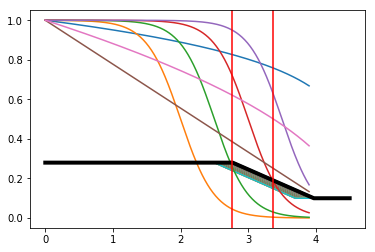

In [4]:
beta_budgets.plot(legend=False)
plt.plot(GrowthCurves)
plt.plot(beta_budgets[9], c='k', lw=4)
plt.axvline(x=np.median(cases['t_latearc']), c='r')
plt.axvline(x=np.median(cases['t_midarc']), c='r')

(2.5, 3.9)

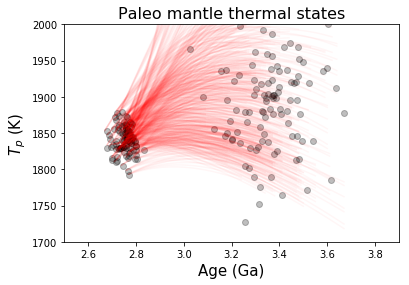

In [5]:
outputs.plot(c='r', alpha=best_alpha/6, legend=False)
calc.superimpose_Archean_temperatures(cases)
plt.ylim(1700,2000)
plt.xlim(2.5, 3.9)

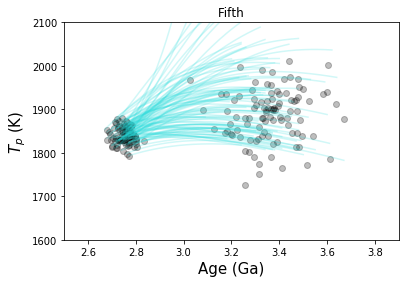

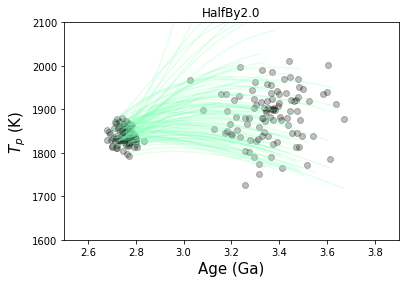

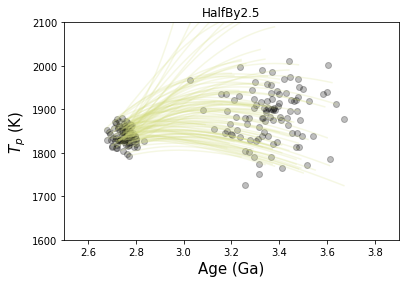

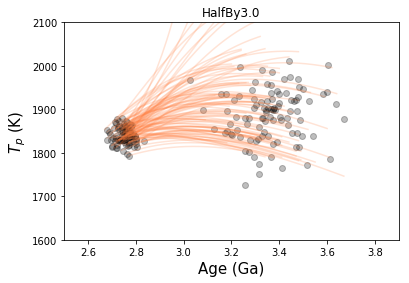

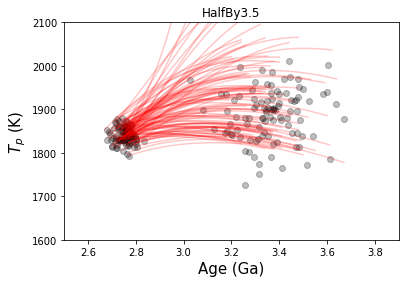

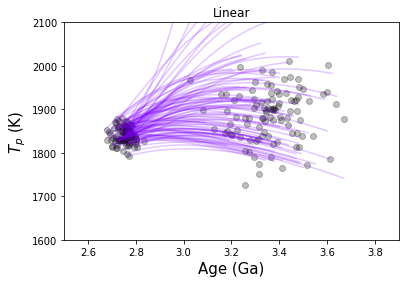

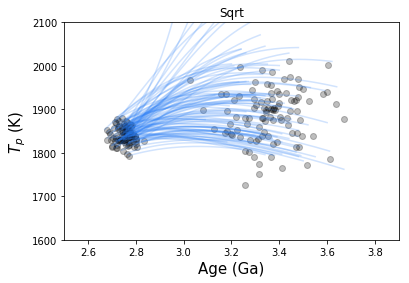

In [6]:
for i in range(len(curves)):
    outputs[outputs.columns[0+i*nruns:(i+1)*nruns]].plot(c=assign_colors(my_cm[curves[i]]), legend=False, alpha=best_alpha)
    calc.superimpose_Archean_temperatures(cases)
    plt.xlim(2.5,3.9)
    plt.title(curves[i])